# Demo
- Create labeled training data
- Generate features
- Train Node Classifier
- Predict

## Graph model
<img src="paysim_model2.png" alt="drawing" width="400"/>

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from neo4j import GraphDatabase

In [2]:
DB_ULR = os.getenv("PAYSIM_URL")
DB_USER = os.getenv("PAYSIM_USER")
DB_PASS = os.getenv("PAYSIM_PASSWORD")
DB_NAME = os.getenv("PAYSIM_DB_NAME")
DB_ENCRYPTED = False


In [3]:
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS), encrypted=DB_ENCRYPTED)

In [4]:
# Let's have a closer look at transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (t:Transaction)
        WITH sum(t.amount) AS globalSum, count(t) AS globalCnt
        WITH *, 10^3 AS scaleFactor
        UNWIND ['CashIn', 'CashOut', 'Payment', 'Debit', 'Transfer'] AS txType
        CALL apoc.cypher.run('MATCH (t:' + txType + ')
            RETURN sum(t.amount) as txAmount, count(t) AS txCnt', {})
        YIELD value
        RETURN txType,value.txAmount AS TotalMarketValue,
        100*round(scaleFactor*(toFloat(value.txAmount)/toFloat(globalSum)))
            /scaleFactor AS `%MarketValue`,
        100*round(scaleFactor*(toFloat(value.txCnt)/toFloat(globalCnt)))
            /scaleFactor AS `%MarketTransactions`,
        toInteger(toFloat(value.txAmount)/toFloat(value.txCnt)) AS AvgTransactionValue,
        value.txCnt AS NumberOfTransactions
        ORDER BY `%MarketTransactions` DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,txType,TotalMarketValue,%MarketValue,%MarketTransactions,AvgTransactionValue,NumberOfTransactions
0,CashIn,2.078963e+10,43.7,46.1,139493,149037
1,CashOut,9.617113e+09,20.2,23.5,126502,76023
2,Payment,6.530112e+08,1.4,23.1,8756,74577
3,Transfer,1.647720e+10,34.6,6.0,846721,19460
4,Debit,2.580165e+07,0.1,1.4,5874,4392


In [5]:
# Find clients with flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        //MATCH (c:Client)-[]->(t:Transaction)
        MATCH (c:Client)-[:PERFORMED]->(t:Transfer)
        WHERE t.fraud=true
        RETURN c.name, COUNT(t) AS flagged_transactions ORDER BY flagged_transactions DESC limit 20
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,flagged_transactions
0,Angel Dominguez,9
1,Maya Talley,7
2,Sebastian Oneill,7
3,Thomas Jennings,6
4,Scarlett Maynard,6
5,Stella Pope,5
6,Benjamin Riley,5
7,Ethan Travis,5
8,Logan Maxwell,5
9,Kimberly Eaton,5


In [6]:
# Label client as fraudster if involved in flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        //WHERE size( (c)-[]->(:Transaction{fraud:true})  ) > 4
        WHERE size( (c)-[]->(:Transfer{fraud:true})  ) > 2
        set c.is_fraudster = 1
        return count(*) as numberOfFlaggedFraudsters
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)


,numberOfFlaggedFraudsters
0,378


In [7]:
# Inmemory projection using cypher
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.graph.create.cypher(
            'client_graph', 
            'MATCH (c:Client) where ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) ) return id(c) as id', 
            'MATCH (c:Client)-[:PERFORMED]->(t:Transfer)-[:TO]->(c2:Client) return id(c) as source, id(c2) as target, sum(t.amount) as amount, "TRANSACTED_WITH" as type '
        )
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (c:Client) where ( (c)-[:PERFORMED]->(:T...,MATCH (c:Client)-[:PERFORMED]->(t:Transfer)-[:...,client_graph,2407,19007,78


In [8]:
# Louvain stats
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.stats('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0.123534,[0.12353401633929903],1,389,"{'p99': 17, 'min': 1, 'max': 28, 'mean': 6.187...",4,0,143,"{'maxIterations': 10, 'seedProperty': None, 'c..."


In [9]:
# Save louvain results
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true,
            writeProperty:'LouvainCommunity'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,33,2407,0.122646,[0.12264586756116681],1,387,"{'p99': 19, 'min': 1, 'max': 25, 'mean': 6.219...",2,0,121,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [10]:
# Find fraudlent communities ( louvain )
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH c.LouvainCommunity as louvain_id, count(c) as num_members
        WHERE num_members > $cap
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        RETURN louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        ORDER BY fraction_fraud DESC
        """,
        cap = 10
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,louvain_id,num_members,count_fraudsters,fraction_fraud
0,207,12,11,0.916667
1,85,11,8,0.727273
2,311,11,8,0.727273
3,128,16,11,0.687500
4,131,14,9,0.642857
5,253,11,7,0.636364
6,187,13,8,0.615385
7,287,12,7,0.583333
8,133,16,9,0.562500
9,203,11,6,0.545455


In [30]:
%%html
<iframe src="http://localhost:7474/bloom/?search=ShowCommunity%20128&perspective=GDSFraudPerspective&run=true" width="1000" height="600"></iframe>

In [12]:
# Label the "innocent" ( Clients in communities with few flagged transactions )
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH c.LouvainCommunity as louvain_id, count(c) as num_members
        WHERE num_members > 4
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        WITH louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        WHERE fraction_fraud < 0.1
        MATCH (c:Client) WHERE c.LouvainCommunity=louvain_id
        AND ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) )
        SET c.is_fraudster=0
        return count(*) as numberOfFlaggedInnocent
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,numberOfFlaggedInnocent
0,120


In [13]:
# Define our model data
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE c.is_fraudster=0 OR c.is_fraudster=1
            SET c:model_data
            RETURN count(*) as result
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,result
0,490


In [14]:
# Label the data we want to make predictions on
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE NOT c:model_data 
            AND ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) )
            SET c:predict_data
            return count(*)
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,count(*)
0,1917


In [15]:
# Create node embedding with FastRP
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.fastRP.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            relationshipWeightProperty:'amount',
            iterationWeights: [0.0, 1.00, 1.00, 0.80, 0.60],
            embeddingDimension:16,
            randomSeed: 1, 
            writeProperty:'embedding'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2407,2407,0,5,38,"{'writeConcurrency': 4, 'relationshipWeightPro..."


In [16]:
# Fetch the embeddings for visualization in python
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:model_data)
            RETURN c.embedding as embedding, c.is_fraudster as class
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    embedding = list(df['embedding'])
    category = list(df['class'])

,embedding,class
0,"[-0.12649892270565033, 0.43519625067710876, -1...",0
1,"[-0.05394425615668297, 0.2710039019584656, -0....",0
2,"[0.10780709981918335, 0.6510238647460938, -1.0...",0
3,"[0.8643039464950562, 0.2589437961578369, -1.43...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
485,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
486,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
487,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
488,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [17]:
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 490 samples in 0.000s...
[t-SNE] Computed neighbors for 490 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 490 / 490
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.913391
[t-SNE] KL divergence after 1000 iterations: 0.955794


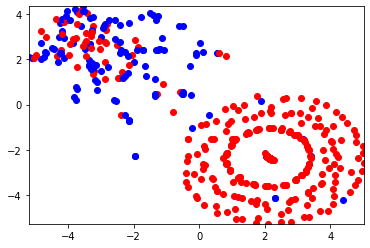

In [18]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot


for label, x, y in zip(category, x_coords, y_coords):
    if label == 0:
        plt.scatter(x, y, color='blue')
    else:
        plt.scatter(x, y, color='red')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


In [19]:
# Calculate some additional "graph features"
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.degree.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'degree'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """  
        CALL gds.pageRank.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'pageRank'
        });  
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.triangleCount.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'triangles'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2407,"{'p99': 44.00023651123047, 'min': 0.0, 'max': ...",4,10,0,0,"{'orientation': 'NATURAL', 'writeConcurrency':..."


,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,25,2407,20,False,"{'p99': 1.666365623474121, 'min': 0.1499996185...",5,0,25,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
0,4,2407,550,2407,0,0,5,"{'writeConcurrency': 4, 'writeProperty': 'tria..."


In [20]:
# Calculate some additional "graph features" using cypher
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction)
            WITH c, count(t) as num_transaction, sum(t.amount) as total_transaction_volume
            SET c.num_transactions=num_transaction, c.total_transaction_amnt=total_transaction_volume;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction{fraud:true})
            WITH c, count(t) as num_frauds
            SET c.num_frauds=num_frauds;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

""


""


In [21]:
# Create projection with model data
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('fraud_graph',
            {
                Client:{
                    label:'model_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'num_frauds': {'pro...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",fraud_graph,490,0,15


In [22]:
# Train node classification & pick the best model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.train('fraud_graph', {
            nodeLabels: ['Client'],
            modelName: 'fraud-model',
            featureProperties: ['embedding', 'triangles','num_frauds','num_transactions','pageRank'], 
            targetProperty: 'is_fraudster', 
            metrics: ['F1_WEIGHTED','ACCURACY'], 
            holdoutFraction: 0.2, 
            validationFolds: 5, 
            randomSeed: 2,
            params: [
                {penalty: 0, maxEpochs: 1000},
                {penalty: 0.5, maxEpochs: 1000},
                {penalty: 1.0, maxEpochs: 1000}
                ]
                }) YIELD modelInfo
            RETURN
            modelInfo.bestParameters AS winningModel,
            modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
            modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxEpochs': 1000, 'minEpochs': 1, 'penalty':...",0.872611,0.904325


In [23]:
# Create projection with predict_data 
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('predict_graph',
            {
                Client:{
                    label:'predict_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'num_frauds': {'pro...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",predict_graph,1917,0,21


In [24]:
# Make the predictions using node classification model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.predict.mutate('predict_graph', {
                nodeLabels: ['Client'], //filter our the character nodes
                modelName: 'fraud-model',
                mutateProperty: 'predicted_fraudster',
                predictedProbabilityProperty: 'predicted_fraud_probability'
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,3834,0,0,0,1,"{'modelName': 'fraud-model', 'predictedProbabi..."


In [25]:
# Write the predictions back to the database
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.writeNodeProperties(
                'predict_graph',
                ['predicted_fraudster', 'predicted_fraud_probability'],
                ['Client']
            )
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,43,predict_graph,"[predicted_fraud_probability, predicted_frauds...",3834


In [26]:
# What have we predicted (suspect)
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=1
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Olivia Hendrix,1,0.703528,"[0.2964722319446515, 0.703527768055348]"
1,Bella Kane,1,0.679752,"[0.32024772586915096, 0.6797522741308486]"
2,Owen Whitaker,1,0.677715,"[0.32228473318219175, 0.6777152668178077]"
3,Emma Simpson,1,0.677604,"[0.32239648076348554, 0.6776035192365141]"
4,Julian Cooley,1,0.672974,"[0.3270261238206292, 0.6729738761793703]"
5,Andrew Cooper,1,0.672957,"[0.32704335379296895, 0.6729566462070307]"
6,Natalie Francis,1,0.670386,"[0.3296143479729761, 0.6703856520270234]"
7,Justin Valdez,1,0.669206,"[0.33079426330410794, 0.6692057366958916]"
8,Annabelle Schmidt,1,0.668127,"[0.33187334768212956, 0.66812665231787]"
9,Layla Pace,1,0.668037,"[0.33196273166162316, 0.6680372683383763]"


In [27]:
# What have we predicted (class 0)
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=0
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Evelyn Craig,0,0.953847,"[0.9538471178893265, 0.04615288211067326]"
1,Hailey Figueroa,0,0.924519,"[0.9245187267130931, 0.07548127328690662]"
2,Camila Mccarthy,0,0.919054,"[0.9190542655742134, 0.0809457344257863]"
3,Blake Mccray,0,0.914711,"[0.9147109740840738, 0.08528902591592606]"
4,London Sharp,0,0.910849,"[0.9108491180965852, 0.08915088190341457]"
5,Nolan Duffy,0,0.906308,"[0.9063080280779072, 0.09369197192209254]"
6,Michael Cooper,0,0.906296,"[0.9062955505997943, 0.09370444940020546]"
7,Layla Mercado,0,0.905303,"[0.9053030504513101, 0.0946969495486896]"
8,London Goff,0,0.900600,"[0.9005996317247871, 0.0994003682752126]"
9,Chloe Raymond,0,0.899591,"[0.8995911271853277, 0.10040887281467208]"


In [28]:
# Clean up gds graph and model catalogue 
with driver.session(database = DB_NAME) as session:
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.beta.model.drop('fraud-model')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('client_graph')").consume()
        )
    except:
        print()
    try: 
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('fraud_graph')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('predict_graph')").consume()  
        )
    except:
        print()

In [31]:
# Clean up temporary labels and properties
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:model_data) remove c:model_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:predict_data) remove c:predict_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        remove  c.predicted_fraudster, 
                c.predicted_fraud_probability,
                c.embedding,
                c.LouvainCommunity,
                c.is_fraudster,
                c:model_data,
                c:predict_data
        """).consume()
    )